In [1]:
# Librerías
# ======================================================================================
import networkx as nx
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import random
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

In [2]:
matriz_adyacencia = pd.DataFrame(
  {

      "city_index": ["Tijuana", "Tecate", "Rosarito", "Mexicali", "Ensenada",
                "San Quintin", "San Felipe", "Guerrero Negro"],

      "Tijuana": [0, 52, 20, -1, -1, -1, -1, -1],

      "Tecate": [52, 0, -1, 135, 100, -1, -1, -1],

      "Rosarito": [20, -1, 0, -1, 85, -1, -1, -1],

      "Mexicali": [-1, 135, -1, 0, -1, -1, 197, -1],

      "Ensenada": [-1, 100, 85, -1, 0, 185, 246, -1],

      "San Quintin": [-1, -1, -1, -1, 185, 0, -1, 425],

      "San Felipe": [-1, -1, -1, 197, 246, -1, 0, 394],

      "Guerrero Negro": [-1, -1, -1, -1, -1, 425, 394, 0],
  }
)

matriz_adyacencia = matriz_adyacencia.set_index("city_index")

lista_nodos = ["Tijuana", "Tecate", "Rosarito", "Mexicali", "Ensenada", "San Quintin", "San Felipe", "Guerrero Negro"]

matriz_adyacencia

,Tijuana,Tecate,Rosarito,Mexicali,Ensenada,San Quintin,San Felipe,Guerrero Negro
city_index,,,,,,,,
Tijuana,0,52,20,-1,-1,-1,-1,-1
Tecate,52,0,-1,135,100,-1,-1,-1
Rosarito,20,-1,0,-1,85,-1,-1,-1
Mexicali,-1,135,-1,0,-1,-1,197,-1
Ensenada,-1,100,85,-1,0,185,246,-1
San Quintin,-1,-1,-1,-1,185,0,-1,425
San Felipe,-1,-1,-1,197,246,-1,0,394
Guerrero Negro,-1,-1,-1,-1,-1,425,394,0


## Definición de solucion

In [3]:
class Solucion:
  def __init__(self, camino_solucion):
    self.camino = camino_solucion
    self.fitness_score = 0
    self.llega_al_final = False
    self.es_valida = False
    self.es_elitismo = False

  def reiniciar_atributos(self):
    self.fitness_score = 0
    self.llega_al_final = False
    self.es_valida = False
    self.es_elitismo = False

  def copy(self):
    copia = Solucion(self.camino)
    copia.fitness_score = self.fitness_score
    copia.llega_al_final = self.llega_al_final
    copia.es_valida = self.es_valida
    copia.es_elitismo = self.es_elitismo
    return copia

class Poblacion:
  def __init__(self):
    self.soluciones = []

  def agregar_solucion(self, solucion):
    self.soluciones.append(solucion)

  def ordenar_por_fitness(self):
    self.soluciones = sorted(self.soluciones, key=lambda solucion: solucion.fitness_score)

  def objetivo(self, matriz_adyacencia, ciudad_final):
    for solucion in self.soluciones:
      # Inicializamos todos los atributos de la solucion por defecto
      solucion.reiniciar_atributos() # Asumimos que debido a las modificaciones que pudieron ocurrir, todo está por defecto

      for i in range(len(solucion.camino) - 1):
        if solucion.es_valida == True:
          break

        ciudad_actual = solucion.camino[i]
        ciudad_siguiente = solucion.camino[i+1]

        # Obtener el costo entre ambas ciudades
        costo = matriz_adyacencia.loc[ciudad_actual, ciudad_siguiente]

        # Cada que se avance en el camino, revisar que llega al nodo final
        if ciudad_siguiente == ciudad_final:
            solucion.llega_al_final = True

        if costo != -1:
            solucion.fitness_score += costo
            if solucion.fitness_score < 100000 and solucion.llega_al_final == True: # Si el camino hasta ahora es válido y si llega a la ciudad final
                solucion.es_valida = True
        else:
            # Penalización si no hay conexión directa
            solucion.fitness_score += 100000

      if solucion.llega_al_final == False: # Si la solución no llegó en ningun punto a la ciudad final, penalizarla
        solucion.fitness_score += 50000


  def elitismo(self, new_pob, elit):
    for i in range(0, elit, 1):   #Segun el numero de elitismo se agregara las mejores
      self.soluciones[i].es_elitismo = True
      new_pob.agregar_solucion(self.soluciones[i])  #soluciones de la generacion anterior a la nueva

  def mutacion(self, matriz_adyacencia):
    #mutacion
    for solucion in self.soluciones:
      if (solucion.es_elitismo == False): # Si no es parte del elitismo, puede ser mutado (conservamos los elites)
        prob = random.randint(1,8) #probabilidad de mutacion
        if prob == 1:
          # Escoge aleatoriamente una fila y una columna en la matriz de adyacencia
          index_city1 = random.randint(0, 7)
          # Obtener las ciudades en base a los numeros generados aleatoriamente
          city1 = lista_nodos[index_city1]

          # Agregar a la solucion la ciudad generada aleatoriamente
          solucion.camino[random.randint(1,7)] = city1

  def imprimir(self):
    i = 1
    for solucion in self.soluciones:
      print(f"Solucion {i}")
      print(solucion.camino)
      print(solucion.fitness_score)
      print()
      i = i + 1


def cruce(solucion1, solucion2, nueva_poblacion):
  # Punto de cruce se genera aleatoriamente entre la posición 4 y 7 de los padres
  punto_cruce = random.randint(4, 7)

  aux_sol = solucion1.copy()  # Copia del recorrido del padre1
  aux_sol2 = solucion2.copy()  # Copia del recorrido del padre2

  nueva_poblacion.agregar_solucion(aux_sol)  # Se almacenan las copias de los padres
  nueva_poblacion.agregar_solucion(aux_sol2)  # en la lista auxiliar nueva_poblacion

  # Se intercambian todos los elementos de los padres después del punto de cruce
  for i in range(punto_cruce, len(aux_sol.camino), 1):
      aux_sol.camino[i], aux_sol2.camino[i] = aux_sol2.camino[i], aux_sol.camino[i]


## Definición de funciones

## Crear una solución aleatoria inicial, independientemente de los pesos y si es posible o no

In [11]:
# lista_nodos = ["Tijuana", "Tecate", "Rosarito", "Mexicali", "Ensenada", "San Quintin", "San Felipe", "Guerrero Negro"]

poblacion = Poblacion() # Polacion del conjunto de soluciones

ciudad_final = lista_nodos[-1]     # Punto final (Guerrero Negro)
print(f"Ciudad final escogida: {ciudad_final}")

num_sol = 8

for i in range(num_sol):
  camino_solucion = []   #Donde se guarda la solucion/recorrido

  index_city1 = 0                      # Punto de inicio/ciudad actual (Tijuana)

  # Llenar la lista de solucion con 8 espacios
  for j in range(8):
    # Obtener las ciudades en base a los numeros generados aleatoriamente
    city1 = lista_nodos[index_city1]

    # Agregar a la solucion las ciudades obtenidas junto con su costo
    camino_solucion.append(city1)

    # Elegir un indice aleatoriamente para la siguiente iteracion
    index_city1 = random.randint(0, 7)

  poblacion.agregar_solucion(Solucion(camino_solucion)) # Agregar la solucion a la poblacion (lista)

Ciudad final escogida: Guerrero Negro


In [12]:
print("Población inicial:")
poblacion.imprimir()

Población inicial:
Solucion 1
['Tijuana', 'San Quintin', 'San Felipe', 'San Quintin', 'Ensenada', 'San Felipe', 'San Felipe', 'San Quintin']
0

Solucion 2
['Tijuana', 'San Felipe', 'Guerrero Negro', 'Tijuana', 'Rosarito', 'Rosarito', 'Tijuana', 'Mexicali']
0

Solucion 3
['Tijuana', 'Guerrero Negro', 'Ensenada', 'Mexicali', 'San Quintin', 'Rosarito', 'Ensenada', 'Guerrero Negro']
0

Solucion 4
['Tijuana', 'Mexicali', 'Mexicali', 'Guerrero Negro', 'Mexicali', 'Mexicali', 'Tijuana', 'San Quintin']
0

Solucion 5
['Tijuana', 'Tecate', 'Tijuana', 'San Quintin', 'Tijuana', 'Mexicali', 'Mexicali', 'Mexicali']
0

Solucion 6
['Tijuana', 'San Quintin', 'Rosarito', 'Tecate', 'Tecate', 'San Quintin', 'Rosarito', 'Rosarito']
0

Solucion 7
['Tijuana', 'Tijuana', 'Mexicali', 'Rosarito', 'San Felipe', 'San Quintin', 'San Quintin', 'Ensenada']
0

Solucion 8
['Tijuana', 'San Felipe', 'Ensenada', 'Tecate', 'Tijuana', 'Guerrero Negro', 'Rosarito', 'San Felipe']
0



# Algoritmo genético

In [13]:
max_iteraciones = 1000
num_iter = []
num_fit = []

#Se evalua si el el numero de soluciones es par o impar para determinar el numero de elitismos que habrá
if(num_sol%2) == 0:
    num_elit = 2
else:
    num_elit = 1
print(f"El numero de elitismos es: {num_elit}")

#Ordenar soluciones en base a la calificacion
for iteracion in range(max_iteraciones):
  # Evaluar las soluciones
  poblacion.objetivo(matriz_adyacencia, ciudad_final)

  # Ordenar en base a la evaluacion
  poblacion.ordenar_por_fitness()

  # Registro de ejes para graficacion
  num_iter.append(iteracion)
  num_fit.append(poblacion.soluciones[0].fitness_score)

  # Declaracion de la nueva poblacion
  nueva_poblacion = Poblacion()

  # elitismo, obtener las mejores soluciones segun su evaluacion (Antes del cruce)
  poblacion.elitismo(nueva_poblacion, num_elit)

  # Hacer cruce despues del elitismo
  for i in range(num_elit, num_sol, 2): #numero de cruces depende de elitismo
      cruce(poblacion.soluciones[i], poblacion.soluciones[i+1], nueva_poblacion)
      # i = i + 2

  poblacion = nueva_poblacion  #Se pasa el auxiliar a la poblacion principal(Nueva generacion)

  # mutacion en la nueva poblacion
  poblacion.mutacion(matriz_adyacencia)

  print(f"Población en la iteración: {iteracion}")
  poblacion.imprimir()

El numero de elitismos es: 2
Población en la iteración: 0
Solucion 1
['Tijuana', 'San Felipe', 'Guerrero Negro', 'Tijuana', 'Rosarito', 'Rosarito', 'Tijuana', 'Mexicali']
300434

Solucion 2
['Tijuana', 'Tecate', 'Tijuana', 'San Quintin', 'Tijuana', 'Mexicali', 'Mexicali', 'Mexicali']
350104

Solucion 3
['Tijuana', 'San Felipe', 'Rosarito', 'Tecate', 'San Felipe', 'San Quintin', 'San Quintin', 'Ensenada']
400398

Solucion 4
['Tijuana', 'Tijuana', 'Mexicali', 'Rosarito', 'Tijuana', 'Guerrero Negro', 'Rosarito', 'San Felipe']
450185

Solucion 5
['Tijuana', 'San Quintin', 'San Felipe', 'San Quintin', 'Ensenada', 'San Felipe', 'San Felipe', 'San Quintin']
450431

Solucion 6
['Tijuana', 'Mexicali', 'Mexicali', 'Guerrero Negro', 'Mexicali', 'Mexicali', 'Tijuana', 'San Quintin']
500000

Solucion 7
['Tijuana', 'San Quintin', 'Rosarito', 'Tecate', 'Tecate', 'San Quintin', 'Ensenada', 'Guerrero Negro']
550000

Solucion 8
['Tijuana', 'Guerrero Negro', 'Ensenada', 'Mexicali', 'San Quintin', 'Rosari

In [7]:
print("Conjunto de soluciones después de todos los cambios:")
poblacion.imprimir()

Conjunto de soluciones después de todos los cambios:
Solucion 1
['Tecate', 'Ensenada', 'Ensenada', 'San Quintin', 'Guerrero Negro', 'Mexicali', 'San Felipe', 'Ensenada']
710

Solucion 2
['Tecate', 'Ensenada', 'San Quintin', 'San Quintin', 'Guerrero Negro', 'Guerrero Negro', 'Ensenada', 'Tecate']
710

Solucion 3
['Tecate', 'Tijuana', 'Rosarito', 'Ensenada', 'Ensenada', 'Ensenada', 'San Quintin', 'Guerrero Negro']
50357

Solucion 4
['Tecate', 'Tijuana', 'Rosarito', 'Guerrero Negro', 'San Felipe', 'Ensenada', 'Tecate', 'Ensenada']
101322

Solucion 5
['Tecate', 'Ensenada', 'Mexicali', 'Mexicali', 'Guerrero Negro', 'Rosarito', 'Tijuana', 'Guerrero Negro']
400120

Solucion 6
['Tecate', 'Rosarito', 'Tijuana', 'San Felipe', 'Mexicali', 'Ensenada', 'Tijuana', 'Rosarito']
400237

Solucion 7
['Tecate', 'Tecate', 'Rosarito', 'Tecate', 'Rosarito', 'Mexicali', 'San Quintin', 'Tecate']
550197

Solucion 8
['Tecate', 'Guerrero Negro', 'Rosarito', 'San Felipe', 'San Quintin', 'Tecate', 'San Felipe', 'Ro

## Obtener la mejor solucion en base a la poblacion final

In [8]:
# Obtener la mejor solucion en base a las evaluaciones previas
auxiliar = poblacion.soluciones[0]
mejor_solucion = []

i = 0
while auxiliar.camino[i] != ciudad_final:
  mejor_solucion.append(auxiliar.camino[i])
  i = i + 1

mejor_solucion.append(ciudad_final)
print(mejor_solucion)

['Tecate', 'Ensenada', 'Ensenada', 'San Quintin', 'Guerrero Negro']


## Graficar la mejor solucion junto con su costo

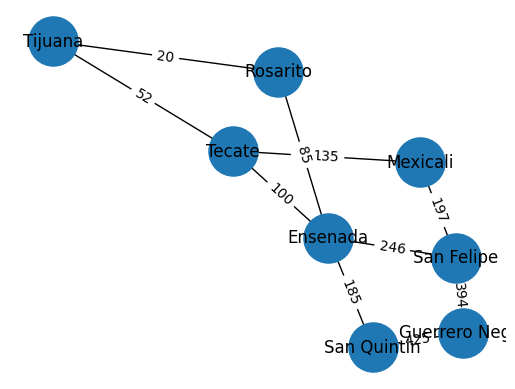

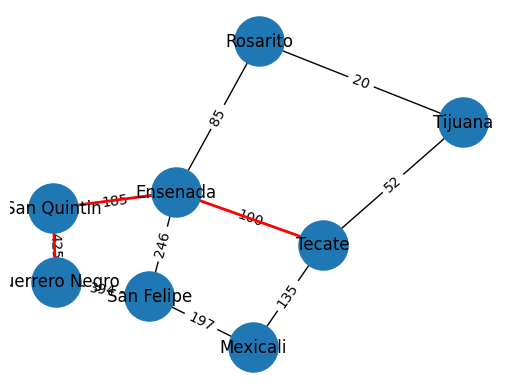

In [9]:
#Graficacion de ploblacion
G = nx.Graph()
nodos = matriz_adyacencia.columns.tolist()
G.add_nodes_from(nodos)

for nodo1 in nodos:
    for nodo2 in nodos:
        peso = matriz_adyacencia.loc[nodo1, nodo2]
        if peso > 0:
            G.add_edge(nodo1, nodo2, weight=peso)

pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=1250)
nx.draw_networkx_edges(G, pos)

labels = {nodo: nodo for nodo in G.nodes()}
nx.draw_networkx_labels(G, pos, labels)

edge_labels = {(nodo1, nodo2): peso['weight'] for nodo1, nodo2, peso in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels)

plt.axis('off')
plt.show()


#Graficacion de solucion final
sol = nx.Graph()
nodos = matriz_adyacencia.columns.tolist()
sol.add_nodes_from(nodos)

for nodo1 in nodos:
    for nodo2 in nodos:
        peso = matriz_adyacencia.loc[nodo1, nodo2]
        if peso > 0:
            sol.add_edge(nodo1, nodo2, weight=peso)

pos = nx.spring_layout(sol)
nx.draw_networkx_nodes(sol, pos, node_size=1250)
nx.draw_networkx_edges(sol, pos)

labels = {nodo: nodo for nodo in G.nodes()}
nx.draw_networkx_labels(sol, pos, labels)

edge_labels = {(nodo1, nodo2): peso['weight'] for nodo1, nodo2, peso in sol.edges(data=True)}
nx.draw_networkx_edge_labels(sol, pos, edge_labels)

resaltado = nx.Graph()

i = 0
for i in range(len(mejor_solucion)-1):
    nodo1, nodo2, peso = mejor_solucion[i], mejor_solucion[i+1], matriz_adyacencia.loc[mejor_solucion[i], mejor_solucion[i+1]]
    #nodo1, nodo2, peso = arista, [arista+1], matriz_adyacencia.loc[arista, [arista+1]]
    resaltado.add_edge(nodo1, nodo2, weight=peso)

nx.draw_networkx_edges(sol, pos, edgelist=list(resaltado.edges()), edge_color='r', width=2)
plt.axis('off')
plt.show()

##Evolucion del Fitness Score

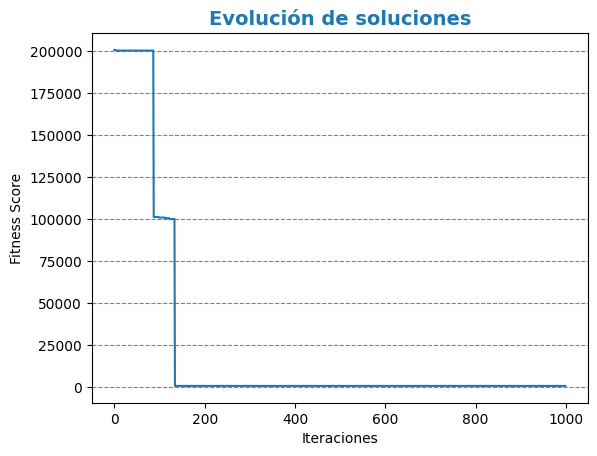

In [10]:
fig, ax = plt.subplots()
ax.plot(num_iter, num_fit)
ax.set_title('Evolución de soluciones', loc = "Center", fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'tab:blue'})
ax.set_xlabel('Iteraciones')
ax.set_ylabel('Fitness Score')
ax.grid(axis = 'y', color = 'gray', linestyle = 'dashed')
#plt.axis([0,10000,0,2000]) <------------- para mas enfoque
plt.show()